## Enhancement of Magnetic Data: Calculating Geophysical Attributes

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import harmonica as hm
import verde as vd
import rioxarray
import xrft
import xarray as xr
import geopandas as gpd
import importlib

In [22]:
import sys
import importlib
sys.path.append('../../modules')
from reading import ascii_xyz
from plotting import raster_plotting
from processing import interpolate

importlib.reload(raster_plotting);

In [23]:
import os
data_dir = os.path.abspath(os.path.join('..', '..', 'data'))
output_dir = os.path.abspath(os.path.join('..', '..', 'output'))

## Data

In [24]:
mask_path = os.path.join(output_dir, "masks", "mask_of_gravity_data.shp")
gdf_mask = gpd.read_file(mask_path)
gdf_mask = gdf_mask.to_crs("EPSG:4326")

filename = os.path.join(output_dir, "raster", "magnetic_anomaly.tif")
data = rioxarray.open_rasterio(filename)

data_masked = data.rio.clip(
    gdf_mask.geometry,
    gdf_mask.crs,
    drop=True,
    invert=False
)

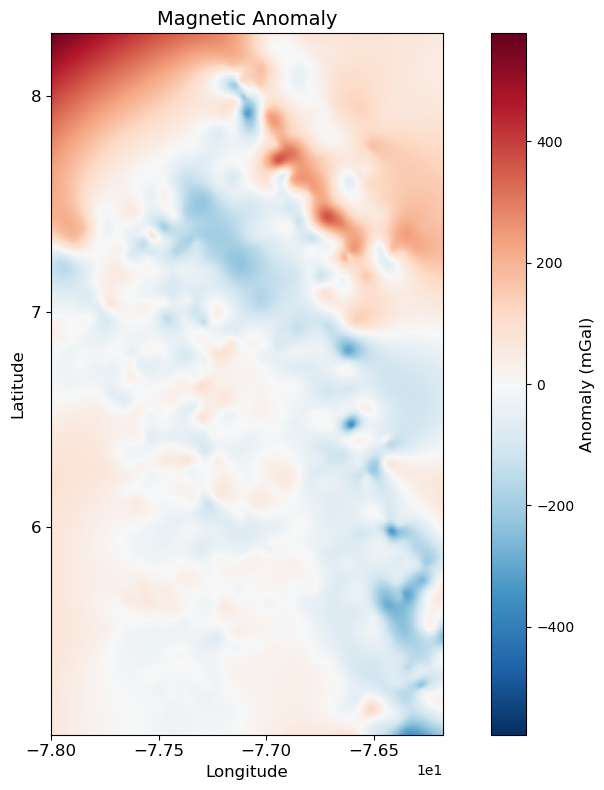

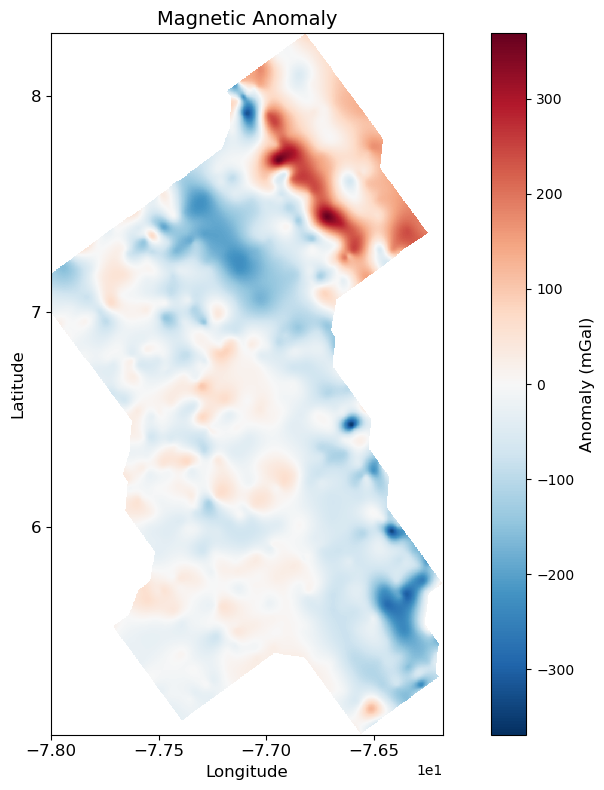

In [25]:
raster_plotting.plot_raster_data(data.x, data.y, data.values[0], sampling=10, data_type='GA',cmap='RdBu_r', title='Magnetic Anomaly')
raster_plotting.plot_raster_data(data_masked.x, data_masked.y, data_masked.values[0], sampling=10, data_type='GA',cmap='RdBu_r', title='Magnetic Anomaly')

## Reduction to Pole

In [26]:
raw_tmi = data.values[0]
data_grid = vd.make_xarray_grid(
    (data.x.values, data.y.values),
    raw_tmi,
    data_names="TMI",
)
valid_mask = np.isfinite(raw_tmi)
data_grid;

In [27]:
data_grid = data_grid.sortby(['easting', 'northing'])
data_grid = data_grid.rio.write_crs("EPSG:4326")

In [28]:
rtp_grid = hm.reduction_to_pole(
    data_grid.TMI.fillna(0), inclination=34, declination=-5
)


c:\Users\jasolanoz\AppData\Local\anaconda3\envs\lineament-detection\Lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


In [29]:
rtp_grid = rtp_grid.rename({"easting": "x", "northing": "y"}).rio.write_crs("EPSG:4326")
rtp_grid = rtp_grid.rio.clip(
    gdf_mask.geometry,
    gdf_mask.crs,
    drop=True,
    invert=False
)

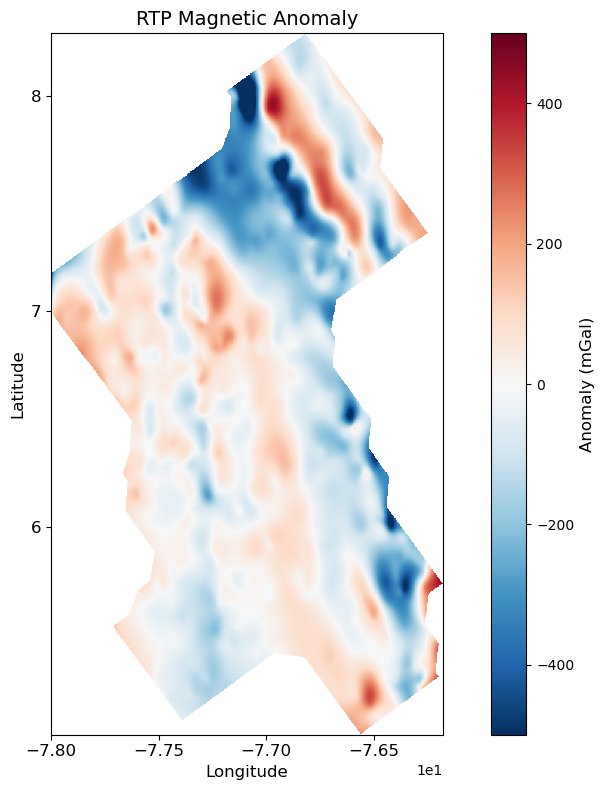

In [30]:
raster_plotting.plot_raster_data(rtp_grid.x, rtp_grid.y, rtp_grid, sampling=10, data_type='GA',cmap='RdBu_r', title='RTP Magnetic Anomaly', vmax=500, vmin=-500)

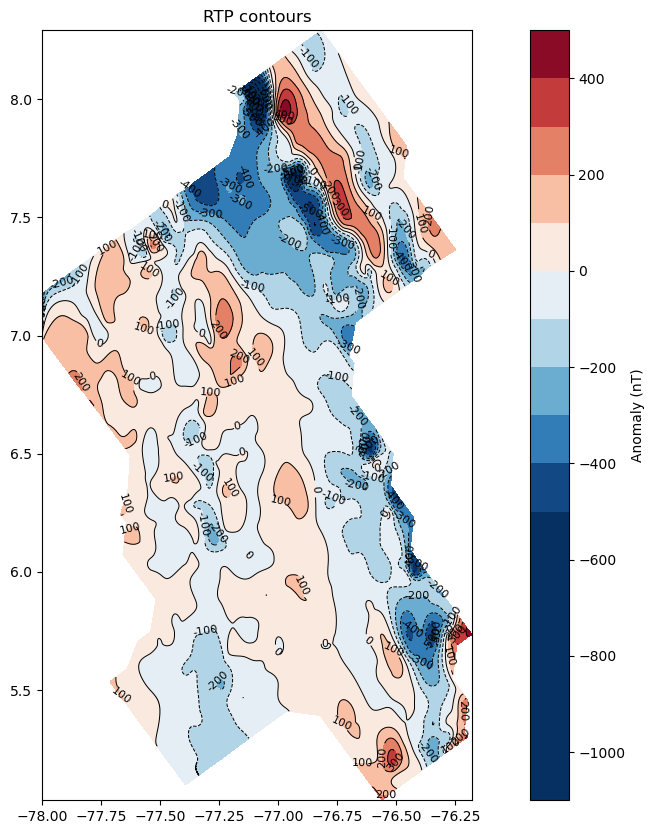

In [31]:
fig, ax = plt.subplots(figsize=(15,10))

cs = ax.contour(rtp_grid.x, rtp_grid.y, rtp_grid.data, levels=15, colors='k', linewidths=0.7, vmax=500, vmin=-500)
ax.clabel(cs, fmt='%d', fontsize=8)

cf = ax.contourf(rtp_grid.x, rtp_grid.y, rtp_grid.data, levels=15, cmap='RdBu_r', vmax=500, vmin=-500)
fig.colorbar(cf, ax=ax, label='Anomaly (nT)')

ax.set_aspect('equal', 'box')
ax.set_title('RTP contours')
plt.show()